## Условие задачи

На основании данных о пассажирах, которые воспользовались метро дважды за сутки, при
наличии информации о первом заходе в метро, необходимо предсказать, **на какой станции**
и **через какой промежуток времени**, этот пассажир воспользуется метро повторно. 

В данных присутствуют только те люди, которые совершили ровно две поездки в день,
при этом статистика валидаций взята за несколько дней.
- `train.csv` — файл, содержащий данные о валидациях для обучения;
-`test.csv` — файл, содержащий данные для предсказания;
- `subway. csv` — вспомогательный файл содержащий информацию о всех
возможных способах попасть со станции «А» на станцию «Б»; 

### Описание датасетов:
- `id` : уникальный идентификатор столбца;
- `ticket_id` : уникальный идентификатор билета, считается, что у одного билета один владелец
- `ticket_type_nm` : тип билета
- `entrance_id` : уникальный id входа в станцию
- `entrance_nm` : название
- `station_id` : уникальное id станции захода
- `station_nm` : наименование станции захода
- `line_id` : уникальный id ветки на, которой находится станция
- `line_nm` : наименование ветки, на которой находится станция
- `pass_dttm` : дата валидации
- `time_to_under` (столбец для предсказания) : сколько времени прошло между первой и второй валидацией
- `label (столбец для предсказания)` : id второй станции, на которой произошла валидация 

## Подготовка данных для задачи классификации

In [15]:
# Импортируем нужные библиотеки
import pandas as pd, numpy as np, time
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, cv, Pool, CatBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import plotly.express as px

In [3]:
# Читаем датасет и оставляем 10000 строк
df = pd.read_csv('train_dataset_train.csv', sep=',')
df = df.drop(df.index[range(10000, 1091021)])

In [4]:
print(df.shape) # размер оставленного датасета

(10000, 12)


In [5]:
df.head() 

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


### Исследование

Обратим внимание на типы проездного билета. Можно заметить, что существуют типы билетов, которые дублируются. Например, `30 дней СК учащегося` и `СК учащегося 30 дней`. Таких пар всего 11. Заменим дубликаты — это поможет сократить количество категорий билета с 43 до 36, а также уменьшит число выбросов.

In [6]:
df.ticket_type_nm.unique() 

array(['Пропуск FacePay', 'СК учащегося 30 дней',
       'БСК дружинника г.Москвы', '30 дней', 'КОШЕЛЕК',
       'СК студента 30 дней', '90 дней', '90 дней ЕДИНЫЙ ТК',
       '30 дней СК учащегося', '90 дней СК студента',
       '30 дней СК студента', 'ББК', 'СК аспиранта 90 дней',
       'Социальная карта москвича', '30 дней ЕДИНЫЙ ТК',
       'Социальная карта жителя Моск. области', '30 дней Пригород ТК',
       'Социальная карта москвича с сопровождающим',
       'Пропуск сотрудника УВД по охране Метрополитена',
       '60 поездок ЕДИНЫЙ ТК', 'СК для сотрудника ГУВД г.Москвы',
       '365 дней ЕДИНЫЙ ТК', 'ВЕСБ МОСКВА (7мин)', 'СК студента 90 дней',
       '90 дней Пригород ТК', '30 дней  Пригород', '365 дней Пригород ТК',
       '365 дней', 'СК ординатора 30 дней', '30 дней СК аспиранта',
       '30 дней СК ординатора', '90 дней СК ординатора',
       'ВЕСБ МО (7 мин)', 'ВЕСБ МО (тип 5)', 'СК ординатора 90 дней',
       'СК аспиранта 30 дней', '90 дней СК учащегося',
       'Времен

In [7]:
df.ticket_type_nm.nunique() #количество различных типов билетов до удаления дубликатов

43

In [8]:
df.replace({'30 дней СК учащегося':'СК учащегося 30 дней', 
              '30 дней СК студента': 'СК студента 30 дней',
              '90 дней СК студента':'СК студента 90 дней',
              '90 дней СК учащегося':'СК учащегося 90 дней',
              '3 суток Единый ТК':'Билет 3 суток ЕДИНЫЙ',
              '30 дней СК ассистента-стажера':'СК ассистента-стажера 30 дней',
              '90 дней СК аспиранта':'СК аспиранта 90 дней',
              '30 дней СК аспиранта':'СК аспиранта 30 дней',
              '90 дней СК аспиранта':'СК аспиранта 90 дней',
              '30 дней СК ординатора':'СК ординатора 30 дней',
              '90 дней СК ординатора':'СК ординатора 90 дней'}, inplace=True)

In [9]:
df.ticket_type_nm.nunique() #количество различных типов билетов после удаления дубликатов

36

Это преобразование оптимизирует расчеты при использовании, например, OheHotEncoder, для дальнейшего решение задачи с помощью метода линейной регрессии. Однако выбранный для работы метод Catboost сам занимается подготовкой категориальных переменных. Было выяснено империческим путем, что данное преобразование внутри `ticket_type_nm` понижает процент угадываний, поэтому от него было принято решение отказаться.

#### Построим график зависимости времени до следующей валидации от типа проездного билета.

In [12]:
df['ticket_type_nm'] = df.ticket_type_nm.apply(lambda x: x.split(' ')[0])

In [41]:
stats1 = df.groupby(['ticket_type_nm'], as_index=False)[['time_to_under']].mean()

In [91]:
gr1 = pd.DataFrame(stats1,columns=['ticket_type_nm','time_to_under'])
fig = px.bar(gr1,y='time_to_under',x='ticket_type_nm', text_auto='.2s',
            title='Зависимость времени до второй валидации от типа билета')
fig.update_traces(textangle=0,
    hovertemplate = '%{y} минут',
    marker_color='blue',

    )
fig.update_xaxes(
        tickangle = 60)
fig.update_yaxes(
)
fig.update_layout(template="plotly_white",height=400, width=950)
fig.show()

Из графика можно заметить, что люди, обладабщие проездными на фиксированное количество дней, пользуются метро реже, чем те, у кого проедной не ограничен по времени.

## Подготовка данных для задачи классификации

Исключим:
- столбцы с не численными, не категориальными переменными - `id`,`ticket_id`,
- дублирующиеся, с точки зрения обучения, столбцы - `station_nm`,`line_id`,`entrance_nm`,
И для задачи классификации - столбцы со временем `pass_dttm`,`time_to_under`.

In [45]:
df.drop(columns=['id','ticket_id','station_nm','line_id','pass_dttm','time_to_under','entrance_nm'],inplace=True)

In [5]:
cols = ['ticket_type_nm', 'entrance_id', 'station_id','line_nm']
for item in cols:
    df[item] = df[item].astype("category").cat.codes +1

In [6]:
df.head()

,ticket_type_nm,entrance_id,station_id,line_nm,label
0,28,385,198,2,8001
1,38,53,30,4,9011
2,21,53,30,4,7022
3,2,53,30,4,2022
4,27,53,30,4,2017


## Классификация Catboost'ом

In [7]:
train, test, y_train, y_test = train_test_split(df.drop(["label"], axis=1), df["label"],
                                                random_state=10, test_size=0.2)

In [8]:
#cat_features_index = [0,1,2,3,4,5,6]

In [9]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03],
         'l2_leaf_reg': [3],
         'iterations': [10]}
#'verbose': False
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)

C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 5.5713420	total: 359ms	remaining: 3.23s
1:	learn: 5.5440303	total: 594ms	remaining: 2.38s
2:	learn: 5.5182055	total: 776ms	remaining: 1.81s
3:	learn: 5.4944294	total: 985ms	remaining: 1.48s
4:	learn: 5.4721407	total: 1.18s	remaining: 1.18s
5:	learn: 5.4522270	total: 1.37s	remaining: 913ms
6:	learn: 5.4300917	total: 1.57s	remaining: 672ms
7:	learn: 5.4089648	total: 1.76s	remaining: 440ms
8:	learn: 5.3892194	total: 1.96s	remaining: 217ms
9:	learn: 5.3700426	total: 2.16s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5670966	total: 206ms	remaining: 1.85s
1:	learn: 5.5399091	total: 434ms	remaining: 1.74s
2:	learn: 5.5139078	total: 620ms	remaining: 1.45s
3:	learn: 5.4906840	total: 813ms	remaining: 1.22s
4:	learn: 5.4665904	total: 1.01s	remaining: 1.01s
5:	learn: 5.4455299	total: 1.2s	remaining: 799ms
6:	learn: 5.4259217	total: 1.39s	remaining: 597ms
7:	learn: 5.4044883	total: 1.58s	remaining: 394ms
8:	learn: 5.3853018	total: 1.77s	remaining: 197ms
9:	learn: 5.3669764	total: 1.97s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5737334	total: 213ms	remaining: 1.92s
1:	learn: 5.5460075	total: 441ms	remaining: 1.76s
2:	learn: 5.5193292	total: 623ms	remaining: 1.45s
3:	learn: 5.4957777	total: 826ms	remaining: 1.24s
4:	learn: 5.4727274	total: 1.03s	remaining: 1.03s
5:	learn: 5.4505157	total: 1.23s	remaining: 820ms
6:	learn: 5.4276298	total: 1.43s	remaining: 612ms
7:	learn: 5.4054386	total: 1.62s	remaining: 405ms
8:	learn: 5.3857787	total: 1.82s	remaining: 202ms
9:	learn: 5.3673168	total: 2.01s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5693397	total: 625ms	remaining: 5.62s
1:	learn: 5.5390992	total: 1.29s	remaining: 5.17s
2:	learn: 5.5089251	total: 2.01s	remaining: 4.69s
3:	learn: 5.4820387	total: 2.64s	remaining: 3.96s
4:	learn: 5.4593092	total: 3.31s	remaining: 3.31s
5:	learn: 5.4349747	total: 3.93s	remaining: 2.62s
6:	learn: 5.4107485	total: 4.61s	remaining: 1.98s
7:	learn: 5.3873460	total: 5.29s	remaining: 1.32s
8:	learn: 5.3658875	total: 5.95s	remaining: 661ms
9:	learn: 5.3434854	total: 6.63s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5634607	total: 660ms	remaining: 5.94s
1:	learn: 5.5331895	total: 1.25s	remaining: 4.99s
2:	learn: 5.5043329	total: 1.91s	remaining: 4.46s
3:	learn: 5.4790313	total: 2.54s	remaining: 3.81s
4:	learn: 5.4585001	total: 2.74s	remaining: 2.74s
5:	learn: 5.4327344	total: 3.47s	remaining: 2.31s
6:	learn: 5.4077565	total: 4.13s	remaining: 1.77s
7:	learn: 5.3844938	total: 4.72s	remaining: 1.18s
8:	learn: 5.3629971	total: 5.31s	remaining: 591ms
9:	learn: 5.3414455	total: 6s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5700879	total: 732ms	remaining: 6.59s
1:	learn: 5.5390000	total: 1.46s	remaining: 5.83s
2:	learn: 5.5096103	total: 2.16s	remaining: 5.05s
3:	learn: 5.4843124	total: 2.81s	remaining: 4.22s
4:	learn: 5.4607947	total: 3.42s	remaining: 3.42s
5:	learn: 5.4353040	total: 4.08s	remaining: 2.72s
6:	learn: 5.4112490	total: 4.75s	remaining: 2.04s
7:	learn: 5.3873552	total: 5.43s	remaining: 1.36s
8:	learn: 5.3647461	total: 6.08s	remaining: 676ms
9:	learn: 5.3421261	total: 6.75s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5688479	total: 5.91s	remaining: 53.1s
1:	learn: 5.5388776	total: 9.79s	remaining: 39.2s
2:	learn: 5.5118543	total: 13.2s	remaining: 30.8s
3:	learn: 5.4829460	total: 16.4s	remaining: 24.7s
4:	learn: 5.4566541	total: 19.8s	remaining: 19.8s
5:	learn: 5.4292868	total: 23.4s	remaining: 15.6s
6:	learn: 5.4045231	total: 27.1s	remaining: 11.6s
7:	learn: 5.3796718	total: 30.3s	remaining: 7.58s
8:	learn: 5.3557558	total: 33.6s	remaining: 3.73s
9:	learn: 5.3335323	total: 36.8s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5646823	total: 4.03s	remaining: 36.3s
1:	learn: 5.5342073	total: 7.72s	remaining: 30.9s
2:	learn: 5.5073681	total: 11.2s	remaining: 26.2s
3:	learn: 5.4805319	total: 14.8s	remaining: 22.2s
4:	learn: 5.4529718	total: 18.3s	remaining: 18.3s
5:	learn: 5.4261387	total: 22s	remaining: 14.6s
6:	learn: 5.3996349	total: 25.5s	remaining: 10.9s
7:	learn: 5.3753511	total: 29.1s	remaining: 7.27s
8:	learn: 5.3505898	total: 32.6s	remaining: 3.62s
9:	learn: 5.3295706	total: 36.2s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5704436	total: 3.73s	remaining: 33.6s
1:	learn: 5.5407312	total: 7.26s	remaining: 29.1s
2:	learn: 5.5150425	total: 11.3s	remaining: 26.3s
3:	learn: 5.4882218	total: 15s	remaining: 22.5s
4:	learn: 5.4599115	total: 18.6s	remaining: 18.6s
5:	learn: 5.4321056	total: 22.5s	remaining: 15s
6:	learn: 5.4066432	total: 26.4s	remaining: 11.3s
7:	learn: 5.3814123	total: 29.9s	remaining: 7.47s
8:	learn: 5.3560823	total: 33.7s	remaining: 3.75s
9:	learn: 5.3360320	total: 36.6s	remaining: 0us


C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 220, in __call__
    return self._score(
  File "C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\blach\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarni

0:	learn: 5.5725419	total: 262ms	remaining: 2.36s
1:	learn: 5.5468785	total: 563ms	remaining: 2.25s
2:	learn: 5.5146047	total: 845ms	remaining: 1.97s
3:	learn: 5.4900099	total: 1.14s	remaining: 1.71s
4:	learn: 5.4649069	total: 1.44s	remaining: 1.44s
5:	learn: 5.4418292	total: 1.7s	remaining: 1.14s
6:	learn: 5.4177269	total: 2.07s	remaining: 888ms
7:	learn: 5.3953764	total: 2.35s	remaining: 589ms
8:	learn: 5.3750754	total: 2.65s	remaining: 295ms
9:	learn: 5.3536626	total: 2.98s	remaining: 0us


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F650FE5840>,
             param_grid={'depth': [4, 7, 10], 'iterations': [10],
                         'l2_leaf_reg': [3], 'learning_rate': [0.03]},
             scoring='roc_auc')

In [10]:
predict=cb_model.predict(test)

In [11]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",cb_model.best_estimator_)
print("\n The best score across ALL searched params:\n",cb_model.best_score_)
print("\n The best parameters across ALL searched params:\n",cb_model.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 nan

 The best parameters across ALL searched params:
 {'depth': 4, 'iterations': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


In [12]:
clf = CatBoostClassifier(depth=4, iterations= 2000, l2_leaf_reg= 3, learning_rate= 0.03)
clf.fit(train,y_train)

0:	learn: 5.5725419	total: 250ms	remaining: 8m 20s
1:	learn: 5.5468785	total: 548ms	remaining: 9m 7s
2:	learn: 5.5146047	total: 854ms	remaining: 9m 28s
3:	learn: 5.4900099	total: 1.15s	remaining: 9m 36s
4:	learn: 5.4649069	total: 1.45s	remaining: 9m 37s
5:	learn: 5.4418292	total: 1.73s	remaining: 9m 35s
6:	learn: 5.4177269	total: 2.06s	remaining: 9m 45s
7:	learn: 5.3953764	total: 2.32s	remaining: 9m 37s
8:	learn: 5.3750754	total: 2.6s	remaining: 9m 36s
9:	learn: 5.3536626	total: 2.91s	remaining: 9m 39s
10:	learn: 5.3343949	total: 3.21s	remaining: 9m 40s
11:	learn: 5.3158792	total: 3.52s	remaining: 9m 43s
12:	learn: 5.2986260	total: 3.82s	remaining: 9m 44s
13:	learn: 5.2840991	total: 4.09s	remaining: 9m 40s
14:	learn: 5.2699606	total: 4.37s	remaining: 9m 38s
15:	learn: 5.2563182	total: 4.65s	remaining: 9m 36s
16:	learn: 5.2416297	total: 4.98s	remaining: 9m 40s
17:	learn: 5.2251750	total: 5.34s	remaining: 9m 47s
18:	learn: 5.2110288	total: 5.68s	remaining: 9m 51s
19:	learn: 5.1978907	tot

158:	learn: 4.5725927	total: 48.6s	remaining: 9m 22s
159:	learn: 4.5700815	total: 48.9s	remaining: 9m 22s
160:	learn: 4.5676719	total: 49.2s	remaining: 9m 22s
161:	learn: 4.5650307	total: 49.5s	remaining: 9m 22s
162:	learn: 4.5638332	total: 49.8s	remaining: 9m 21s
163:	learn: 4.5624714	total: 50.1s	remaining: 9m 20s
164:	learn: 4.5605715	total: 50.4s	remaining: 9m 20s
165:	learn: 4.5586587	total: 50.7s	remaining: 9m 19s
166:	learn: 4.5568599	total: 50.9s	remaining: 9m 19s
167:	learn: 4.5548137	total: 51.3s	remaining: 9m 19s
168:	learn: 4.5531515	total: 51.6s	remaining: 9m 18s
169:	learn: 4.5511398	total: 51.9s	remaining: 9m 18s
170:	learn: 4.5488652	total: 52.2s	remaining: 9m 18s
171:	learn: 4.5471694	total: 52.5s	remaining: 9m 17s
172:	learn: 4.5447362	total: 52.8s	remaining: 9m 17s
173:	learn: 4.5424614	total: 53.1s	remaining: 9m 17s
174:	learn: 4.5401747	total: 53.4s	remaining: 9m 16s
175:	learn: 4.5378375	total: 53.7s	remaining: 9m 16s
176:	learn: 4.5362495	total: 54.1s	remaining: 

313:	learn: 4.3566210	total: 1m 35s	remaining: 8m 34s
314:	learn: 4.3554735	total: 1m 36s	remaining: 8m 33s
315:	learn: 4.3544376	total: 1m 36s	remaining: 8m 33s
316:	learn: 4.3528944	total: 1m 36s	remaining: 8m 33s
317:	learn: 4.3518997	total: 1m 36s	remaining: 8m 32s
318:	learn: 4.3504100	total: 1m 37s	remaining: 8m 32s
319:	learn: 4.3497045	total: 1m 37s	remaining: 8m 32s
320:	learn: 4.3489129	total: 1m 37s	remaining: 8m 31s
321:	learn: 4.3479901	total: 1m 38s	remaining: 8m 31s
322:	learn: 4.3472177	total: 1m 38s	remaining: 8m 30s
323:	learn: 4.3467040	total: 1m 38s	remaining: 8m 30s
324:	learn: 4.3457238	total: 1m 38s	remaining: 8m 30s
325:	learn: 4.3441315	total: 1m 39s	remaining: 8m 30s
326:	learn: 4.3430291	total: 1m 39s	remaining: 8m 29s
327:	learn: 4.3413896	total: 1m 39s	remaining: 8m 29s
328:	learn: 4.3402681	total: 1m 40s	remaining: 8m 29s
329:	learn: 4.3393141	total: 1m 40s	remaining: 8m 29s
330:	learn: 4.3389361	total: 1m 40s	remaining: 8m 28s
331:	learn: 4.3379141	total:

467:	learn: 4.2516785	total: 2m 18s	remaining: 7m 33s
468:	learn: 4.2510331	total: 2m 18s	remaining: 7m 33s
469:	learn: 4.2503854	total: 2m 19s	remaining: 7m 32s
470:	learn: 4.2499651	total: 2m 19s	remaining: 7m 32s
471:	learn: 4.2497315	total: 2m 19s	remaining: 7m 32s
472:	learn: 4.2492381	total: 2m 19s	remaining: 7m 31s
473:	learn: 4.2487861	total: 2m 20s	remaining: 7m 31s
474:	learn: 4.2484233	total: 2m 20s	remaining: 7m 30s
475:	learn: 4.2479071	total: 2m 20s	remaining: 7m 30s
476:	learn: 4.2474522	total: 2m 20s	remaining: 7m 30s
477:	learn: 4.2468509	total: 2m 21s	remaining: 7m 29s
478:	learn: 4.2464019	total: 2m 21s	remaining: 7m 29s
479:	learn: 4.2459442	total: 2m 21s	remaining: 7m 29s
480:	learn: 4.2455185	total: 2m 22s	remaining: 7m 28s
481:	learn: 4.2451841	total: 2m 22s	remaining: 7m 28s
482:	learn: 4.2449315	total: 2m 22s	remaining: 7m 27s
483:	learn: 4.2442125	total: 2m 22s	remaining: 7m 27s
484:	learn: 4.2439539	total: 2m 23s	remaining: 7m 27s
485:	learn: 4.2436862	total:

620:	learn: 4.1819906	total: 3m	remaining: 6m 41s
621:	learn: 4.1816810	total: 3m 1s	remaining: 6m 40s
622:	learn: 4.1807802	total: 3m 1s	remaining: 6m 40s
623:	learn: 4.1801593	total: 3m 1s	remaining: 6m 40s
624:	learn: 4.1798800	total: 3m 1s	remaining: 6m 40s
625:	learn: 4.1794661	total: 3m 2s	remaining: 6m 39s
626:	learn: 4.1793293	total: 3m 2s	remaining: 6m 39s
627:	learn: 4.1789171	total: 3m 2s	remaining: 6m 39s
628:	learn: 4.1781503	total: 3m 3s	remaining: 6m 38s
629:	learn: 4.1779363	total: 3m 3s	remaining: 6m 38s
630:	learn: 4.1775629	total: 3m 3s	remaining: 6m 38s
631:	learn: 4.1774268	total: 3m 3s	remaining: 6m 38s
632:	learn: 4.1772411	total: 3m 4s	remaining: 6m 37s
633:	learn: 4.1768834	total: 3m 4s	remaining: 6m 37s
634:	learn: 4.1763641	total: 3m 4s	remaining: 6m 37s
635:	learn: 4.1757837	total: 3m 5s	remaining: 6m 36s
636:	learn: 4.1754082	total: 3m 5s	remaining: 6m 36s
637:	learn: 4.1749362	total: 3m 5s	remaining: 6m 36s
638:	learn: 4.1747120	total: 3m 6s	remaining: 6m 

774:	learn: 4.1162170	total: 3m 46s	remaining: 5m 57s
775:	learn: 4.1156433	total: 3m 46s	remaining: 5m 57s
776:	learn: 4.1155465	total: 3m 46s	remaining: 5m 57s
777:	learn: 4.1153460	total: 3m 47s	remaining: 5m 56s
778:	learn: 4.1151533	total: 3m 47s	remaining: 5m 56s
779:	learn: 4.1148302	total: 3m 47s	remaining: 5m 56s
780:	learn: 4.1145744	total: 3m 47s	remaining: 5m 55s
781:	learn: 4.1142558	total: 3m 48s	remaining: 5m 55s
782:	learn: 4.1139178	total: 3m 48s	remaining: 5m 55s
783:	learn: 4.1137126	total: 3m 48s	remaining: 5m 54s
784:	learn: 4.1134021	total: 3m 49s	remaining: 5m 54s
785:	learn: 4.1131646	total: 3m 49s	remaining: 5m 54s
786:	learn: 4.1130483	total: 3m 49s	remaining: 5m 53s
787:	learn: 4.1123879	total: 3m 49s	remaining: 5m 53s
788:	learn: 4.1120612	total: 3m 50s	remaining: 5m 53s
789:	learn: 4.1114258	total: 3m 50s	remaining: 5m 53s
790:	learn: 4.1106794	total: 3m 50s	remaining: 5m 52s
791:	learn: 4.1104219	total: 3m 51s	remaining: 5m 52s
792:	learn: 4.1102825	total:

927:	learn: 4.0575497	total: 4m 30s	remaining: 5m 12s
928:	learn: 4.0568854	total: 4m 30s	remaining: 5m 12s
929:	learn: 4.0564552	total: 4m 31s	remaining: 5m 11s
930:	learn: 4.0560662	total: 4m 31s	remaining: 5m 11s
931:	learn: 4.0557645	total: 4m 31s	remaining: 5m 11s
932:	learn: 4.0554416	total: 4m 31s	remaining: 5m 10s
933:	learn: 4.0552162	total: 4m 32s	remaining: 5m 10s
934:	learn: 4.0550012	total: 4m 32s	remaining: 5m 10s
935:	learn: 4.0548230	total: 4m 32s	remaining: 5m 9s
936:	learn: 4.0544972	total: 4m 32s	remaining: 5m 9s
937:	learn: 4.0542296	total: 4m 33s	remaining: 5m 9s
938:	learn: 4.0539833	total: 4m 33s	remaining: 5m 9s
939:	learn: 4.0536366	total: 4m 33s	remaining: 5m 8s
940:	learn: 4.0535211	total: 4m 34s	remaining: 5m 8s
941:	learn: 4.0530254	total: 4m 34s	remaining: 5m 8s
942:	learn: 4.0522434	total: 4m 34s	remaining: 5m 7s
943:	learn: 4.0519708	total: 4m 34s	remaining: 5m 7s
944:	learn: 4.0515658	total: 4m 35s	remaining: 5m 7s
945:	learn: 4.0511391	total: 4m 35s	re

1079:	learn: 4.0037053	total: 5m 14s	remaining: 4m 27s
1080:	learn: 4.0035367	total: 5m 14s	remaining: 4m 27s
1081:	learn: 4.0033464	total: 5m 14s	remaining: 4m 26s
1082:	learn: 4.0032272	total: 5m 14s	remaining: 4m 26s
1083:	learn: 4.0029772	total: 5m 15s	remaining: 4m 26s
1084:	learn: 4.0021350	total: 5m 15s	remaining: 4m 26s
1085:	learn: 4.0019173	total: 5m 15s	remaining: 4m 25s
1086:	learn: 4.0013488	total: 5m 16s	remaining: 4m 25s
1087:	learn: 4.0010989	total: 5m 16s	remaining: 4m 25s
1088:	learn: 4.0008377	total: 5m 16s	remaining: 4m 24s
1089:	learn: 4.0006134	total: 5m 16s	remaining: 4m 24s
1090:	learn: 4.0003253	total: 5m 17s	remaining: 4m 24s
1091:	learn: 4.0000534	total: 5m 17s	remaining: 4m 24s
1092:	learn: 3.9998374	total: 5m 17s	remaining: 4m 23s
1093:	learn: 3.9992842	total: 5m 18s	remaining: 4m 23s
1094:	learn: 3.9987904	total: 5m 18s	remaining: 4m 23s
1095:	learn: 3.9985750	total: 5m 18s	remaining: 4m 22s
1096:	learn: 3.9983565	total: 5m 19s	remaining: 4m 22s
1097:	lear

1229:	learn: 3.9538470	total: 5m 57s	remaining: 3m 43s
1230:	learn: 3.9533919	total: 5m 57s	remaining: 3m 43s
1231:	learn: 3.9531226	total: 5m 57s	remaining: 3m 43s
1232:	learn: 3.9527232	total: 5m 58s	remaining: 3m 42s
1233:	learn: 3.9525705	total: 5m 58s	remaining: 3m 42s
1234:	learn: 3.9522824	total: 5m 58s	remaining: 3m 42s
1235:	learn: 3.9518245	total: 5m 58s	remaining: 3m 41s
1236:	learn: 3.9516512	total: 5m 59s	remaining: 3m 41s
1237:	learn: 3.9514428	total: 5m 59s	remaining: 3m 41s
1238:	learn: 3.9509036	total: 5m 59s	remaining: 3m 40s
1239:	learn: 3.9505677	total: 5m 59s	remaining: 3m 40s
1240:	learn: 3.9502536	total: 6m	remaining: 3m 40s
1241:	learn: 3.9498438	total: 6m	remaining: 3m 40s
1242:	learn: 3.9494104	total: 6m	remaining: 3m 39s
1243:	learn: 3.9491903	total: 6m 1s	remaining: 3m 39s
1244:	learn: 3.9490091	total: 6m 1s	remaining: 3m 39s
1245:	learn: 3.9486055	total: 6m 1s	remaining: 3m 38s
1246:	learn: 3.9483537	total: 6m 1s	remaining: 3m 38s
1247:	learn: 3.9479911	tot

1380:	learn: 3.9074112	total: 6m 40s	remaining: 2m 59s
1381:	learn: 3.9073216	total: 6m 40s	remaining: 2m 59s
1382:	learn: 3.9071082	total: 6m 40s	remaining: 2m 58s
1383:	learn: 3.9065672	total: 6m 40s	remaining: 2m 58s
1384:	learn: 3.9063715	total: 6m 41s	remaining: 2m 58s
1385:	learn: 3.9058600	total: 6m 41s	remaining: 2m 57s
1386:	learn: 3.9056985	total: 6m 41s	remaining: 2m 57s
1387:	learn: 3.9054294	total: 6m 42s	remaining: 2m 57s
1388:	learn: 3.9051434	total: 6m 42s	remaining: 2m 57s
1389:	learn: 3.9047458	total: 6m 42s	remaining: 2m 56s
1390:	learn: 3.9043640	total: 6m 42s	remaining: 2m 56s
1391:	learn: 3.9040225	total: 6m 43s	remaining: 2m 56s
1392:	learn: 3.9036755	total: 6m 43s	remaining: 2m 55s
1393:	learn: 3.9033924	total: 6m 43s	remaining: 2m 55s
1394:	learn: 3.9030350	total: 6m 44s	remaining: 2m 55s
1395:	learn: 3.9025902	total: 6m 44s	remaining: 2m 54s
1396:	learn: 3.9024327	total: 6m 44s	remaining: 2m 54s
1397:	learn: 3.9023436	total: 6m 44s	remaining: 2m 54s
1398:	lear

1530:	learn: 3.8648593	total: 7m 22s	remaining: 2m 15s
1531:	learn: 3.8647179	total: 7m 22s	remaining: 2m 15s
1532:	learn: 3.8645253	total: 7m 23s	remaining: 2m 15s
1533:	learn: 3.8643662	total: 7m 23s	remaining: 2m 14s
1534:	learn: 3.8642896	total: 7m 23s	remaining: 2m 14s
1535:	learn: 3.8641009	total: 7m 24s	remaining: 2m 14s
1536:	learn: 3.8637308	total: 7m 24s	remaining: 2m 13s
1537:	learn: 3.8635785	total: 7m 24s	remaining: 2m 13s
1538:	learn: 3.8633685	total: 7m 24s	remaining: 2m 13s
1539:	learn: 3.8632020	total: 7m 25s	remaining: 2m 12s
1540:	learn: 3.8630539	total: 7m 25s	remaining: 2m 12s
1541:	learn: 3.8628695	total: 7m 25s	remaining: 2m 12s
1542:	learn: 3.8627139	total: 7m 25s	remaining: 2m 12s
1543:	learn: 3.8626582	total: 7m 26s	remaining: 2m 11s
1544:	learn: 3.8624376	total: 7m 26s	remaining: 2m 11s
1545:	learn: 3.8622787	total: 7m 26s	remaining: 2m 11s
1546:	learn: 3.8621627	total: 7m 27s	remaining: 2m 10s
1547:	learn: 3.8618275	total: 7m 27s	remaining: 2m 10s
1548:	lear

1681:	learn: 3.8248190	total: 8m 7s	remaining: 1m 32s
1682:	learn: 3.8245827	total: 8m 7s	remaining: 1m 31s
1683:	learn: 3.8244717	total: 8m 7s	remaining: 1m 31s
1684:	learn: 3.8242237	total: 8m 8s	remaining: 1m 31s
1685:	learn: 3.8240396	total: 8m 8s	remaining: 1m 30s
1686:	learn: 3.8235247	total: 8m 8s	remaining: 1m 30s
1687:	learn: 3.8233661	total: 8m 9s	remaining: 1m 30s
1688:	learn: 3.8228087	total: 8m 9s	remaining: 1m 30s
1689:	learn: 3.8226232	total: 8m 9s	remaining: 1m 29s
1690:	learn: 3.8223341	total: 8m 10s	remaining: 1m 29s
1691:	learn: 3.8222098	total: 8m 10s	remaining: 1m 29s
1692:	learn: 3.8220775	total: 8m 10s	remaining: 1m 28s
1693:	learn: 3.8219935	total: 8m 10s	remaining: 1m 28s
1694:	learn: 3.8219345	total: 8m 11s	remaining: 1m 28s
1695:	learn: 3.8217677	total: 8m 11s	remaining: 1m 28s
1696:	learn: 3.8216180	total: 8m 11s	remaining: 1m 27s
1697:	learn: 3.8215451	total: 8m 11s	remaining: 1m 27s
1698:	learn: 3.8214053	total: 8m 12s	remaining: 1m 27s
1699:	learn: 3.8213

1832:	learn: 3.7873012	total: 8m 49s	remaining: 48.2s
1833:	learn: 3.7871622	total: 8m 49s	remaining: 47.9s
1834:	learn: 3.7869862	total: 8m 49s	remaining: 47.6s
1835:	learn: 3.7865768	total: 8m 50s	remaining: 47.4s
1836:	learn: 3.7864354	total: 8m 50s	remaining: 47.1s
1837:	learn: 3.7860010	total: 8m 51s	remaining: 46.8s
1838:	learn: 3.7857990	total: 8m 51s	remaining: 46.5s
1839:	learn: 3.7856157	total: 8m 51s	remaining: 46.2s
1840:	learn: 3.7854496	total: 8m 51s	remaining: 45.9s
1841:	learn: 3.7852111	total: 8m 52s	remaining: 45.6s
1842:	learn: 3.7850151	total: 8m 52s	remaining: 45.4s
1843:	learn: 3.7849890	total: 8m 52s	remaining: 45.1s
1844:	learn: 3.7848568	total: 8m 52s	remaining: 44.8s
1845:	learn: 3.7845633	total: 8m 53s	remaining: 44.5s
1846:	learn: 3.7844619	total: 8m 53s	remaining: 44.2s
1847:	learn: 3.7842935	total: 8m 53s	remaining: 43.9s
1848:	learn: 3.7837507	total: 8m 54s	remaining: 43.6s
1849:	learn: 3.7836303	total: 8m 54s	remaining: 43.3s
1850:	learn: 3.7833564	total

1986:	learn: 3.7498673	total: 9m 33s	remaining: 3.75s
1987:	learn: 3.7495870	total: 9m 33s	remaining: 3.46s
1988:	learn: 3.7495082	total: 9m 34s	remaining: 3.17s
1989:	learn: 3.7494181	total: 9m 34s	remaining: 2.89s
1990:	learn: 3.7492594	total: 9m 34s	remaining: 2.6s
1991:	learn: 3.7490311	total: 9m 35s	remaining: 2.31s
1992:	learn: 3.7485966	total: 9m 35s	remaining: 2.02s
1993:	learn: 3.7483649	total: 9m 35s	remaining: 1.73s
1994:	learn: 3.7483270	total: 9m 35s	remaining: 1.44s
1995:	learn: 3.7480726	total: 9m 36s	remaining: 1.15s
1996:	learn: 3.7478531	total: 9m 36s	remaining: 866ms
1997:	learn: 3.7477597	total: 9m 36s	remaining: 577ms
1998:	learn: 3.7472041	total: 9m 37s	remaining: 289ms
1999:	learn: 3.7470944	total: 9m 37s	remaining: 0us


In [13]:
predict=clf.predict(test)

In [14]:
from sklearn.metrics import r2_score, recall_score, mean_absolute_percentage_error
print('recall: ', recall_score(y_test, predict, average='micro'))

recall:  0.1245


## Регрессия Catboost'ом

In [46]:
#Заново подгрузим таблицу. Не оптимально, но надежно
df1 = pd.read_csv('train_dataset_train.csv')
df1.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


Подготовим данные: разобьем данные в столбце `pass_dttm` на дни недели и часы.

In [47]:
df1.pass_dttm = pd.to_datetime(df1.pass_dttm)
df1['day'] = df1.pass_dttm.dt.dayofweek #день недели
df1['hour'] = df1.pass_dttm.dt.hour # час в формате 24
df1['workday'] = df1['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)
df1 = df1.drop(columns=['pass_dttm'])

Объединим некоторые категории билетов.

In [48]:
df1['ticket_type_nm'] = df1.ticket_type_nm.apply(lambda x: x.split(' ')[0])

In [49]:
df1 = df1.drop(['ticket_id','id','station_id', 'line_id','entrance_id','entrance_nm','label'], axis=1)

In [50]:
df1.head()

,ticket_type_nm,station_nm,line_nm,time_to_under,day,hour,workday
0,Пропуск,Лефортово,Большая кольцевая,216.316667,0,5,1
1,СК,Войковская,Замоскворецкая,648.183333,0,5,1
2,БСК,Войковская,Замоскворецкая,865.333333,0,5,1
3,30,Войковская,Замоскворецкая,1048.233333,0,5,1
4,КОШЕЛЕК,Войковская,Замоскворецкая,965.600000,0,5,1


### Исследование

Узнаем, в какие часы больше всего посетителей в метро. 

In [85]:
unique_hours=df1.hour.unique()
n_hours=df1['hour'].value_counts()

Text(0.5, 0, 'Время входа в метро')

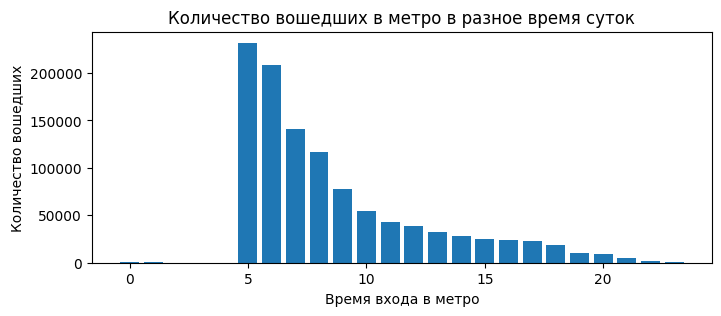

In [86]:
plt.figure(figsize=(8,3))
plt.bar(unique_hours, n_hours,)
plt.title('Количество вошедших в метро в разное время суток')
plt.ylabel('Количество вошедших')
plt.xlabel('Время входа в метро')

Из графика можно сделать вывод, что большая часть людей заходит в метро в промежуток с 5 до 6 утра, затем количество вошедших убывает.

## Продолжение метода регрессии

In [20]:
from sklearn.model_selection import train_test_split
train1, test1, y_train1, y_test1 = train_test_split(df1.drop(['time_to_under'],  axis=1), df1['time_to_under'], test_size=0.4, random_state=42)

In [21]:
cat_features=['ticket_type_nm', 'station_nm', 'line_nm','workday']

In [22]:
model = CatBoostRegressor(iterations=225,
                          learning_rate=0.1,
                          cat_features=cat_features,
                          l2_leaf_reg=0.01,
                          random_strength=0.3,
                          depth=16)

In [23]:
model.fit(train1, y_train1)

0:	learn: 221.3041523	total: 1.21s	remaining: 4m 31s
1:	learn: 211.4947467	total: 2.39s	remaining: 4m 26s
2:	learn: 203.1451891	total: 3.4s	remaining: 4m 11s
3:	learn: 196.1039486	total: 4.52s	remaining: 4m 9s
4:	learn: 190.2084200	total: 5.83s	remaining: 4m 16s
5:	learn: 185.2954405	total: 6.99s	remaining: 4m 15s
6:	learn: 181.1834652	total: 8.16s	remaining: 4m 14s
7:	learn: 177.7909266	total: 9.07s	remaining: 4m 6s
8:	learn: 174.9652296	total: 10.2s	remaining: 4m 5s
9:	learn: 172.6386199	total: 11.5s	remaining: 4m 7s
10:	learn: 170.7271704	total: 12.7s	remaining: 4m 6s
11:	learn: 169.1517164	total: 13.8s	remaining: 4m 4s
12:	learn: 167.8505023	total: 14.9s	remaining: 4m 3s
13:	learn: 166.7791812	total: 16s	remaining: 4m
14:	learn: 165.8961419	total: 17s	remaining: 3m 58s
15:	learn: 165.1422388	total: 18.2s	remaining: 3m 58s
16:	learn: 164.4581650	total: 19.3s	remaining: 3m 56s
17:	learn: 163.9057858	total: 20.4s	remaining: 3m 55s
18:	learn: 163.4362007	total: 21.5s	remaining: 3m 53s


151:	learn: 153.8818503	total: 3m 16s	remaining: 1m 34s
152:	learn: 153.8201173	total: 3m 17s	remaining: 1m 33s
153:	learn: 153.7988940	total: 3m 19s	remaining: 1m 31s
154:	learn: 153.7452595	total: 3m 20s	remaining: 1m 30s
155:	learn: 153.6899217	total: 3m 21s	remaining: 1m 29s
156:	learn: 153.6644797	total: 3m 22s	remaining: 1m 27s
157:	learn: 153.6029622	total: 3m 24s	remaining: 1m 26s
158:	learn: 153.5483651	total: 3m 25s	remaining: 1m 25s
159:	learn: 153.4980891	total: 3m 27s	remaining: 1m 24s
160:	learn: 153.4612192	total: 3m 28s	remaining: 1m 22s
161:	learn: 153.4359484	total: 3m 29s	remaining: 1m 21s
162:	learn: 153.4161095	total: 3m 31s	remaining: 1m 20s
163:	learn: 153.3734446	total: 3m 32s	remaining: 1m 19s
164:	learn: 153.3617238	total: 3m 33s	remaining: 1m 17s
165:	learn: 153.3082530	total: 3m 34s	remaining: 1m 16s
166:	learn: 153.2453285	total: 3m 36s	remaining: 1m 15s
167:	learn: 153.2281396	total: 3m 37s	remaining: 1m 13s
168:	learn: 153.1765976	total: 3m 38s	remaining:

In [24]:
pred = model.predict(test1)
from sklearn.metrics import r2_score, recall_score, mean_absolute_percentage_error
print('R2: ', r2_score(y_test1, pred))

R2:  0.5115700267184482


## Окончательный результат

In [25]:
R2= r2_score(y_test1, pred)
recall = recall_score(y_test, predict, average='micro')
print('result: ',(recall+R2)/2)

result:  0.31803501335922413
